# Predict Future Sales

kaggle link : https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview

Second part of feauture enginering and ML modeling - testing advanced models and advanced features

issues:
* check the unexepected high variations
* check when 0 and when sth
* check the high number of 0
those are big portion of the targets

kaggle link : https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns; sns.set()
from dateutil.relativedelta import relativedelta

import plotly.express as px

In [2]:
from my_functions import merge_basic, convert_silver, completion_semi_gold, scaler, inversed_scale, consolidation_prediction, plot_prediction, preparing_to_predict, plot_metrics

In [3]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

### Data

In [4]:
daily_train = pd.read_csv('sales_train.csv')
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
categories = pd.read_csv('item_categories.csv')
sample_submission = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')

### Data modeling

In [5]:
train_merge = merge_basic(daily_train, test)

In [6]:
train_merge.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,ID,SaleDate
0,02.01.2013,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,150983,2013-01-02
1,03.01.2013,0,25,2574,399.0,2.0,DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,56520,2013-01-03
2,05.01.2013,0,25,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,56520,2013-01-05
3,07.01.2013,0,25,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,56520,2013-01-07
4,08.01.2013,0,25,2574,399.0,2.0,DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,56520,2013-01-08


In [7]:
wholedata_silver = convert_silver(train_merge)

In [8]:
wholedata_silver.head()

,SaleDateMY,date_block_num,shop_id,item_id,item_category_name,item_category_id,item_cnt_day,shopitem
0,2013-01-01,0,2,33,Кино - Blu-Ray,37,1.0,2-33
1,2013-01-01,0,2,482,Программы - 1С:Предприятие 8,73,1.0,2-482
2,2013-01-01,0,2,491,Программы - 1С:Предприятие 8,73,1.0,2-491
3,2013-01-01,0,2,839,Программы - 1С:Предприятие 8,73,1.0,2-839
4,2013-01-01,0,2,1007,Подарки - Развитие,67,3.0,2-1007


<b> Splitting strategy:

* time series expanding window of one period, Take 7 months
* over the first fold, make the functions and features for modeling and prediction (avoid leakage)
* lags and seasons are features
* use rmse as metric
* consider the outputs of the EDA
* goal, predict november or yyyy-11-01

#### The validation data

In [9]:
wholedata_silver.SaleDateMY.max()

Timestamp('2015-10-01 00:00:00')

In [10]:
test_dates = [datetime.datetime(2014, 11, 1), datetime.datetime(2015, 4, 1), datetime.datetime(2015, 5, 1), datetime.datetime(2015, 6, 1), datetime.datetime(2015, 7, 1), datetime.datetime(2015, 8, 1),
datetime.datetime(2015, 9, 1), datetime.datetime(2015, 10, 1),]

In [11]:
whole_test_data = wholedata_silver[wholedata_silver.SaleDateMY.isin(test_dates)][['SaleDateMY','date_block_num','shop_id','item_id','item_cnt_day']]

#### hold-out Train

In [12]:
date_val = datetime.datetime(2014, 10, 1)

In [13]:
train_window = wholedata_silver[wholedata_silver.SaleDateMY < date_val ].copy()
val_window = wholedata_silver[wholedata_silver.SaleDateMY == date_val ][['SaleDateMY','shop_id','item_id','item_cnt_day']].copy()

In [14]:
train_window.head()

,SaleDateMY,date_block_num,shop_id,item_id,item_category_name,item_category_id,item_cnt_day,shopitem
0,2013-01-01,0,2,33,Кино - Blu-Ray,37,1.0,2-33
1,2013-01-01,0,2,482,Программы - 1С:Предприятие 8,73,1.0,2-482
2,2013-01-01,0,2,491,Программы - 1С:Предприятие 8,73,1.0,2-491
3,2013-01-01,0,2,839,Программы - 1С:Предприятие 8,73,1.0,2-839
4,2013-01-01,0,2,1007,Подарки - Развитие,67,3.0,2-1007


In [15]:
train_window.SaleDateMY.max(), train_window.SaleDateMY.min()

(Timestamp('2014-09-01 00:00:00'), Timestamp('2013-01-01 00:00:00'))

In [16]:
train_full = completion_semi_gold(train_window)

In [17]:
train_full.head()

,shop_id,item_id,shopitem,item_category_id,Date,Sale,Order
0,2,30,2-30,40,2013-01-01,0.0,1
1,2,31,2-31,37,2013-01-01,0.0,1
2,2,32,2-32,40,2013-01-01,0.0,1
3,2,33,2-33,37,2013-01-01,1.0,1
4,2,76,2-76,37,2013-01-01,0.0,1


### Exploration

#### Low number of observation of time series

In [18]:
df = train_full.assign( poss = np.where(train_full.Sale > 0, 1, 0) )\
    .pivot_table(index = 'shopitem', values = ['poss','Sale'], aggfunc = {'poss':'sum', 'Sale':'max'} )\
    .sort_values('poss', ascending = False)

In [19]:
group1 = df[df.poss > 10].sort_values('Sale', ascending = False)

In [20]:
group1.Sale.describe()

count    6404.000000
mean       13.983604
std        39.319948
min         1.000000
25%         3.000000
50%         6.000000
75%        12.000000
max      1305.000000
Name: Sale, dtype: float64

In [21]:
group2 = df[(df.poss > 5) & (df.poss <= 10)].sort_values('Sale', ascending = False)

In [22]:
group2.Sale.describe()

count    10665.000000
mean         4.990248
std          8.604325
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max        219.000000
Name: Sale, dtype: float64

In [23]:
group3 = df[(df.poss <= 5)].sort_values('Sale', ascending = False)

In [24]:
group3.Sale.describe()

count    40136.000000
mean         2.371412
std          4.814202
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        210.000000
Name: Sale, dtype: float64

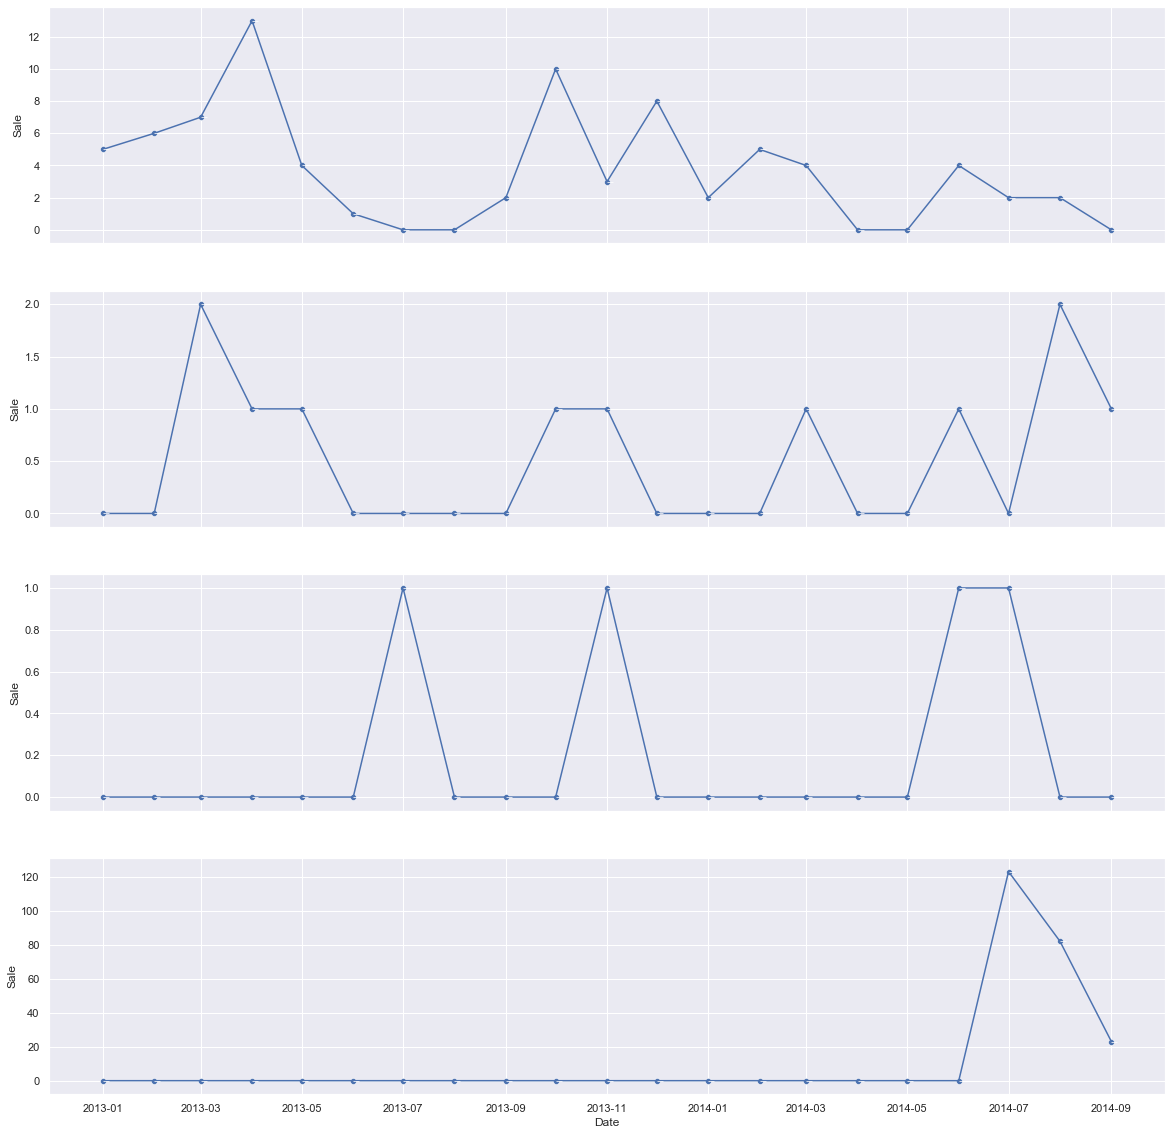

In [25]:
fig, axs = plt.subplots(nrows=4, ncols=1,figsize=(20,20), sharex=True)
ax = sns.lineplot(ax = axs[0] , data = train_full[train_full.shopitem == '16-21488' ] , x="Date", y="Sale", marker = True, )
ax = sns.scatterplot(ax = axs[0] , data = train_full[train_full.shopitem == '16-21488' ] , x="Date", y="Sale", s = 35 )

ax = sns.lineplot(ax = axs[1] , data = train_full[train_full.shopitem == '19-18344' ] , x="Date", y="Sale", marker = True, )
ax = sns.scatterplot(ax = axs[1] , data = train_full[train_full.shopitem == '19-18344' ] , x="Date", y="Sale", s = 35 )

ax = sns.lineplot(ax = axs[2] , data = train_full[train_full.shopitem == '14-16136' ] , x="Date", y="Sale", marker = True, )
ax = sns.scatterplot(ax = axs[2] , data = train_full[train_full.shopitem == '14-16136' ] , x="Date", y="Sale", s = 35 )

ax = sns.lineplot(ax = axs[3] , data = train_full[train_full.shopitem == '42-16790' ] , x="Date", y="Sale", marker = True, )
ax = sns.scatterplot(ax = axs[3] , data = train_full[train_full.shopitem == '42-16790' ] , x="Date", y="Sale", s = 35 )

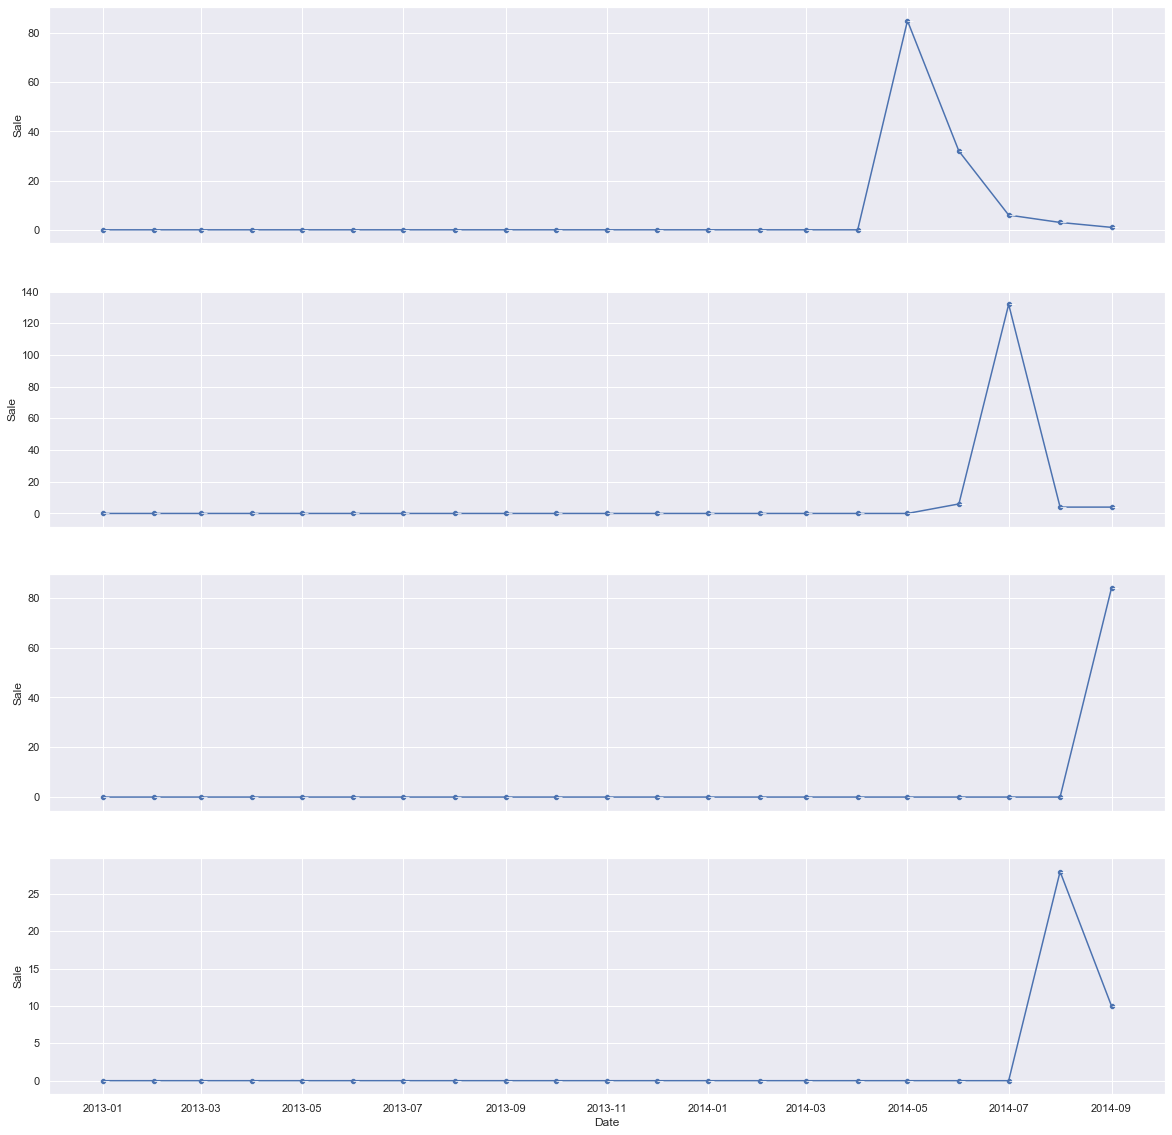

In [26]:
fig, axs = plt.subplots(nrows=4, ncols=1,figsize=(20,20), sharex=True)
ax = sns.lineplot(ax = axs[0] , data = train_full[train_full.shopitem == '25-7805' ] , x="Date", y="Sale", marker = True, )
ax = sns.scatterplot(ax = axs[0] , data = train_full[train_full.shopitem == '25-7805' ] , x="Date", y="Sale", s = 35 )

ax = sns.lineplot(ax = axs[1] , data = train_full[train_full.shopitem == '22-2964' ] , x="Date", y="Sale", marker = True, )
ax = sns.scatterplot(ax = axs[1] , data = train_full[train_full.shopitem == '22-2964' ] , x="Date", y="Sale", s = 35 )

ax = sns.lineplot(ax = axs[2] , data = train_full[train_full.shopitem == '31-2780' ] , x="Date", y="Sale", marker = True, )
ax = sns.scatterplot(ax = axs[2] , data = train_full[train_full.shopitem == '31-2780' ] , x="Date", y="Sale", s = 35 )

ax = sns.lineplot(ax = axs[3] , data = train_full[train_full.shopitem == '31-6376' ] , x="Date", y="Sale", marker = True, )
ax = sns.scatterplot(ax = axs[3] , data = train_full[train_full.shopitem == '31-6376' ] , x="Date", y="Sale", s = 35 )

In [27]:
poss_train = train_full.assign( poss = np.where(train_full.Sale > 0, 1, 0) )
poss_train['max'] = poss_train.groupby(['shopitem']).Sale.transform(lambda x: x.max())
poss_train['Count'] = poss_train.groupby(['shopitem']).poss.transform(lambda x: x.sum())

In [28]:
poss_train[poss_train.Count < 5].sort_values('max', ascending = False).head()

,shop_id,item_id,shopitem,item_category_id,Date,Sale,Order,poss,max,Count
1080339,55,7967,55-7967,34,2014-07-01,5.0,19,1,162.0,3
165059,55,7967,55-7967,34,2013-03-01,0.0,3,0,162.0,3
965929,55,7967,55-7967,34,2014-05-01,0.0,17,0,162.0,3
851519,55,7967,55-7967,34,2014-03-01,0.0,15,0,162.0,3
794314,55,7967,55-7967,34,2014-02-01,0.0,14,0,162.0,3


(734868.0, 735478.0)

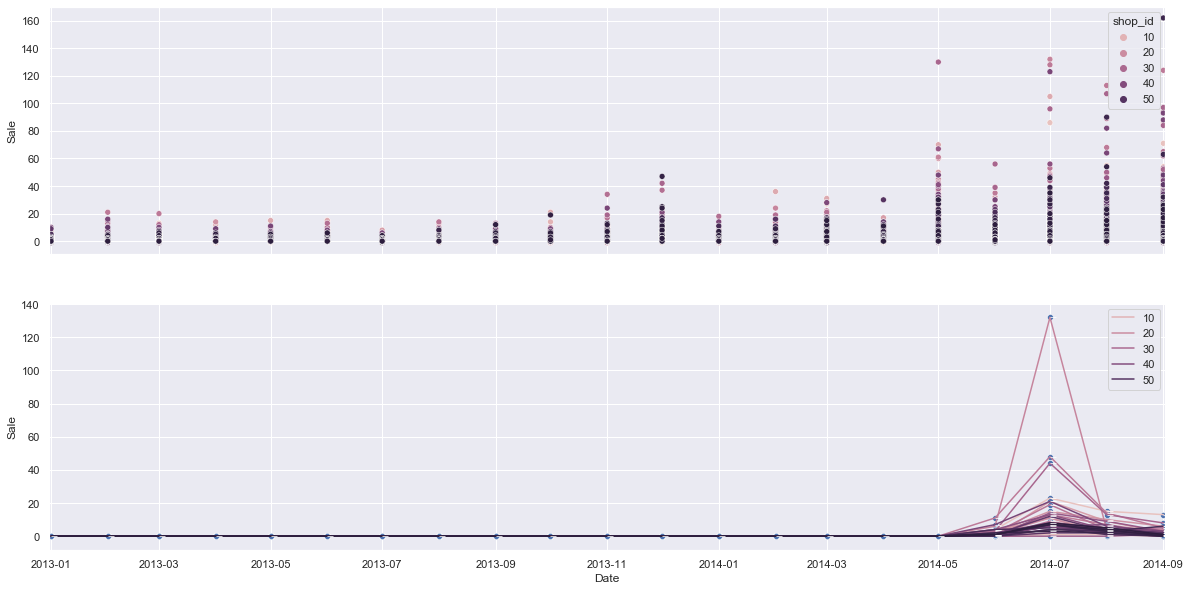

In [29]:
fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(20,10), sharex=True)

ax = sns.scatterplot(ax = axs[0] , data = poss_train[(poss_train.Count < 5) ] , x="Date", y="Sale", s = 35, hue = 'shop_id' )

ax = sns.lineplot(ax = axs[1] , data = poss_train[(poss_train.Count < 5) & (poss_train.item_id == 2964)] , x="Date", y="Sale", marker = True, hue = 'shop_id' )
ax = sns.scatterplot(ax = axs[1] , data = poss_train[(poss_train.Count < 5) & (poss_train.item_id == 2964)] , x="Date", y="Sale", s = 35 )
plt.xlim(poss_train.Date.min() - datetime.timedelta(days=1), poss_train.Date.max() + datetime.timedelta(days=1) )

seems that the shopid has some info about unexpected time series

In [30]:
sample = poss_train[poss_train.Count < 5].copy()
sample['maxshop'] = sample.groupby(['shop_id']).Sale.transform('max')

(734868.0, 735478.0)

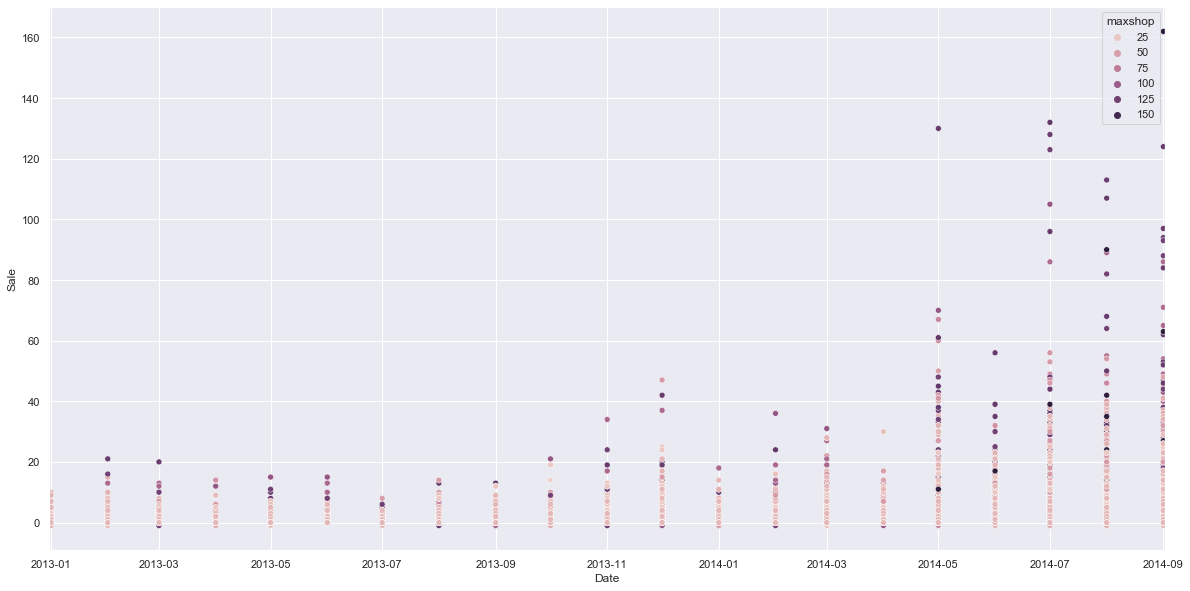

In [31]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(20,10), sharex=True)

ax = sns.scatterplot(ax = axs , data = sample , x="Date", y="Sale", s = 35, hue = 'maxshop' )

plt.xlim(poss_train.Date.min() - datetime.timedelta(days=1), poss_train.Date.max() + datetime.timedelta(days=1) )

issues:
* in 2 two year observations, more than 10 obsservations is quite good and this corresponds to very high amounts or sales
* from 5 to 10 observations the amounts are still high but note that 

<b> Detecting high and Very high Variations

In [32]:
lag_train = poss_train.copy()
lag_train['SaleL1M'] = lag_train.sort_values('Date').groupby(['shopitem'])['Sale'].shift(1)
lag_train = lag_train.assign(L0M_L1M = lag_train.Sale - lag_train.SaleL1M)

lag_train['maxVar'] = lag_train.groupby(['shopitem']).L0M_L1M.transform('max')
lag_train['minVar'] = lag_train.groupby(['shopitem']).L0M_L1M.transform('min')

lag_train = lag_train.assign( noVar = np.where(lag_train.L0M_L1M == 0, 1, 0) )
lag_train['countNoVar'] = lag_train.groupby(['shopitem']).noVar.transform('sum')

In [33]:
lag_train[(lag_train.maxVar > 10) & (lag_train.minVar < 2) ].head()

,shop_id,item_id,shopitem,item_category_id,Date,Sale,Order,poss,max,Count,SaleL1M,L0M_L1M,maxVar,minVar,noVar,countNoVar
15,2,806,2-806,49,2013-01-01,0.0,1,0,14.0,7,NaN,NaN,12.0,-1.0,0,11
41,2,1495,2-1495,30,2013-01-01,0.0,1,0,20.0,8,NaN,NaN,12.0,-11.0,0,10
49,2,1857,2-1857,20,2013-01-01,0.0,1,0,21.0,10,NaN,NaN,21.0,-19.0,0,12
59,2,2269,2-2269,30,2013-01-01,0.0,1,0,18.0,11,NaN,NaN,18.0,-11.0,0,12
82,2,2780,2-2780,20,2013-01-01,0.0,1,0,27.0,1,NaN,NaN,27.0,0.0,0,19


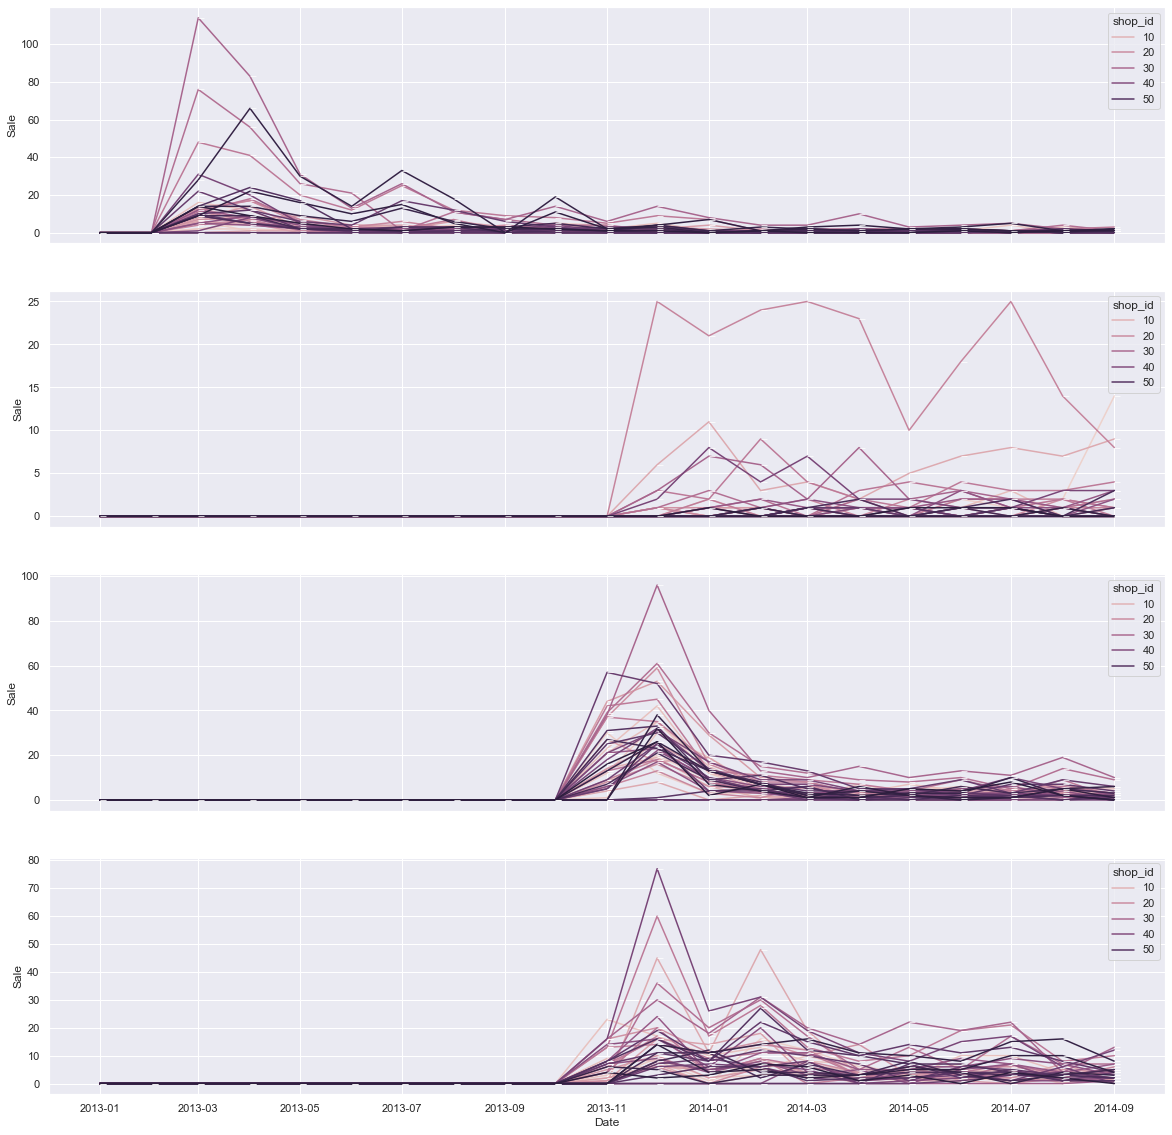

In [34]:
fig, axs = plt.subplots(nrows=4, ncols=1,figsize=(20,20), sharex=True)
ax = sns.lineplot(ax = axs[0] , data = lag_train[lag_train.item_id == 21440 ] , x="Date", y="Sale", marker = True, hue = 'shop_id' )
ax = sns.lineplot(ax = axs[1] , data = lag_train[lag_train.item_id == 806 ] , x="Date", y="Sale", marker = True, hue = 'shop_id' )
ax = sns.lineplot(ax = axs[2] , data = lag_train[lag_train.item_id == 1495 ] , x="Date", y="Sale", marker = True, hue = 'shop_id' )
ax = sns.lineplot(ax = axs[3] , data = lag_train[lag_train.item_id == 5672 ] , x="Date", y="Sale", marker = True, hue = 'shop_id' )

In [35]:
lag_train[(lag_train.maxVar > 10) & (lag_train.minVar < 2) ].pivot_table(index = 'shop_id', values = 'shopitem', aggfunc = lambda x: len(x.unique())).sort_values('shopitem',ascending = False).head()

,shopitem
shop_id,
31,306
25,251
28,220
57,153
42,151


In [36]:
lag_train[(lag_train.maxVar > 10) & (lag_train.minVar < 2) ].pivot_table(index = 'item_category_id', values = 'shopitem', aggfunc = lambda x: len(x.unique())).sort_values('shopitem',ascending = False).head()

,shopitem
item_category_id,
30,794
20,416
40,395
19,347
23,171


In [67]:
lag_train[(lag_train.maxVar > 10) & (lag_train.minVar < 2) ].pivot_table(index = 'item_id', values = 'shopitem', aggfunc = lambda x: len(x.unique())).sort_values('shopitem',ascending = False).head(20)

,shopitem
item_id,
16790,39
7807,39
3928,39
20949,39
6675,38
3331,37
7805,37
7018,37
6738,36


In [68]:
testdflag_detect = lag_train[(lag_train.maxVar > 10) & (lag_train.minVar < 2) ].copy()
testdflag_detect = testdflag_detect.assign(possitionMax = np.where(testdflag_detect.L0M_L1M == testdflag_detect.maxVar, testdflag_detect.Order, 0))
testdflag_detect = testdflag_detect.assign(MonthMax = np.where(testdflag_detect.L0M_L1M == testdflag_detect.maxVar, testdflag_detect.Date.dt.month, 0))
testdflag_detect['pivotx'] = testdflag_detect.groupby(['shopitem']).possitionMax.transform('max')
testdflag_detect = testdflag_detect.assign(befExplotion = np.where(testdflag_detect.Order < testdflag_detect.pivotx , 1, 0))
testdflag_detect['SumBefExplotion'] = testdflag_detect.groupby(['shopitem']).befExplotion.transform('sum')

In [69]:
testdflag_detect.pivot_table(index = 'shopitem', values = 'SumBefExplotion', aggfunc = 'max').describe()

,SumBefExplotion
count,3055.000000
mean,11.230769
std,5.693558
min,1.000000
25%,8.000000
50%,11.000000
75%,16.000000
max,20.000000


in average 11 to 12 months before the explosion 

In [70]:
testdflag_detect[testdflag_detect.Date >= '2013-10-01'].pivot_table(index = 'MonthMax', values = 'shopitem', aggfunc = 'count')

,shopitem
MonthMax,
0,34539
1,20
2,103
3,267
4,77
5,206
6,115
7,99
8,179


In [71]:
def q2(x):
    return x.quantile(0.50)

def q3(x):
    return x.quantile(0.95)

lag_train[(lag_train.maxVar > 10) & (lag_train.minVar < 2) ].groupby('Date').agg( median = ('L0M_L1M', q2),
                              q75 = ('L0M_L1M', q3),
                              Max = ('L0M_L1M', 'max'),)

,median,q75,Max
Date,,,
2013-01-01,NaN,NaN,NaN
2013-02-01,0.0,6.0,117.0
2013-03-01,0.0,18.0,259.0
2013-04-01,0.0,1.0,151.0
2013-05-01,0.0,5.0,497.0
2013-06-01,0.0,7.0,683.0
2013-07-01,0.0,3.0,49.0
2013-08-01,0.0,8.0,229.0
2013-09-01,0.0,24.0,548.0


In [72]:
testdflag_detect[testdflag_detect.MonthMax != 0].groupby('item_id').agg( median = ('L0M_L1M', q2),
                              q75 = ('L0M_L1M', q3),
                              Max = ('L0M_L1M', 'max'),)

,median,q75,Max
item_id,,,
30,17.0,61.65,112.0
31,17.0,43.60,47.0
32,12.0,12.00,12.0
482,16.5,18.75,19.0
486,15.0,15.00,15.0
...,...,...,...
22088,14.0,20.00,23.0
22092,14.5,18.75,20.0
22145,12.0,20.10,21.0


In [73]:
testdflag_detect[testdflag_detect.MonthMax != 0].groupby('shop_id').agg( median = ('L0M_L1M', q2),
                              q75 = ('L0M_L1M', q3),
                              Max = ('L0M_L1M', 'max'),)

,median,q75,Max
shop_id,,,
2,15.5,46.80,66.0
3,15.5,51.85,155.0
4,16.0,48.50,102.0
5,18.0,35.40,67.0
6,19.0,96.30,269.0
7,18.0,58.00,162.0
10,16.0,45.60,67.0
12,21.0,216.75,431.0
14,18.5,48.75,130.0


<b> Modeling this feature

In [74]:
## Requirements maxVar and minVar

df_feature = lag_train[(lag_train.maxVar > 10) & (lag_train.minVar < 2) ]\
    [['shop_id','item_id','shopitem','item_category_id','Date', 'Sale','Order', 'L0M_L1M','maxVar']].copy()

df_feature['Month'] = df_feature['Date'].dt.month
df_feature['pivotDiff'] = np.where(df_feature.Sale == 0, 0,1)
df_feature['reorder1'] = df_feature.sort_values(['Date'], ascending=[True]).groupby(['shopitem','pivotDiff']).cumcount() + 1
df_feature['Starter'] = np.where((df_feature.pivotDiff == 1) & (df_feature.reorder1 == 1),df_feature.Order,0)

df_feature['pivotMax'] = df_feature.groupby(['shopitem']).Starter.transform('max')
df_feature['OrderBef'] = np.where(df_feature.Order < df_feature.pivotMax, df_feature.Order,0)
df_feature['pivotSep'] = np.where(df_feature.OrderBef > 0 ,1,0)

df_feature['reorder'] = df_feature.sort_values(['Date'], ascending=[True]).groupby(['shopitem','pivotSep']).cumcount() + 1
df_feature['capture'] = np.where(df_feature.pivotSep == 1, 1,np.where((df_feature.pivotSep == 0) & (df_feature.reorder <= 3),1,0 ) )
df_feature = df_feature[df_feature.capture == 1]

some stats of my feature

[Text(0.5, 1.0, 'month start explosion')]

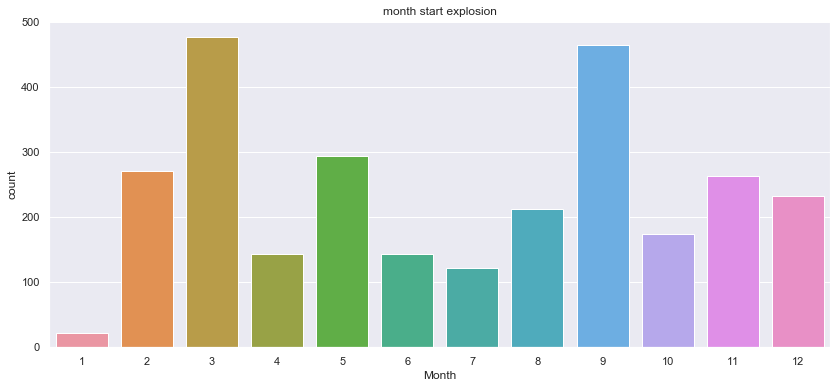

In [75]:
lpots = df_feature[df_feature.Starter != 0 ].groupby('Month').agg(count = ('L0M_L1M', 'count')).reset_index()

fig = plt.figure(figsize=(14,6))
ax = sns.barplot(x="Month", y="count", data=lpots)
ax.set(title='month start explosion')

[Text(0.5, 1.0, 'months 0 to explosion')]

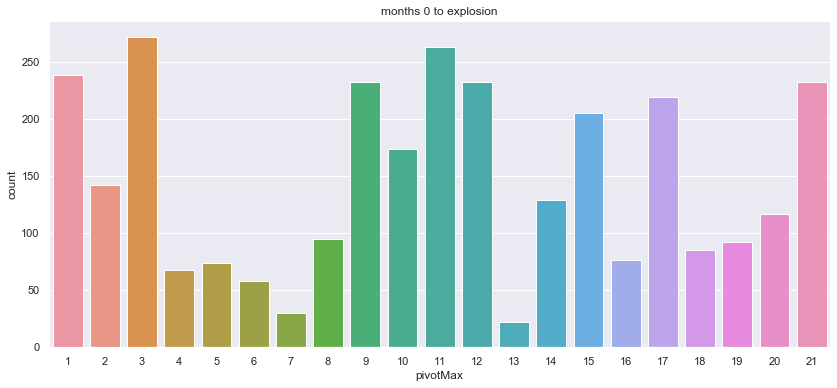

In [76]:
lpots = df_feature.groupby('pivotMax').agg(count = ('shopitem', lambda x: len(x.unique()) )).reset_index()

fig = plt.figure(figsize=(14,6))
ax = sns.barplot(x="pivotMax", y="count", data=lpots)
ax.set(title='months 0 to explosion')

[Text(0.5, 1.0, 'shops in explosion')]

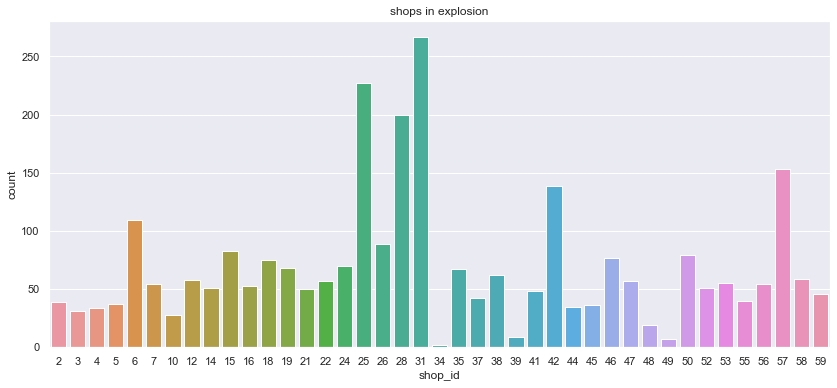

In [77]:
lpots = df_feature[df_feature.Starter != 0 ].groupby('shop_id').agg(count = ('L0M_L1M', 'count')).reset_index()

fig = plt.figure(figsize=(14,6))
ax = sns.barplot(x="shop_id", y="count", data=lpots)
ax.set(title='shops in explosion')

[Text(0.5, 1.0, 'shops in explosion')]

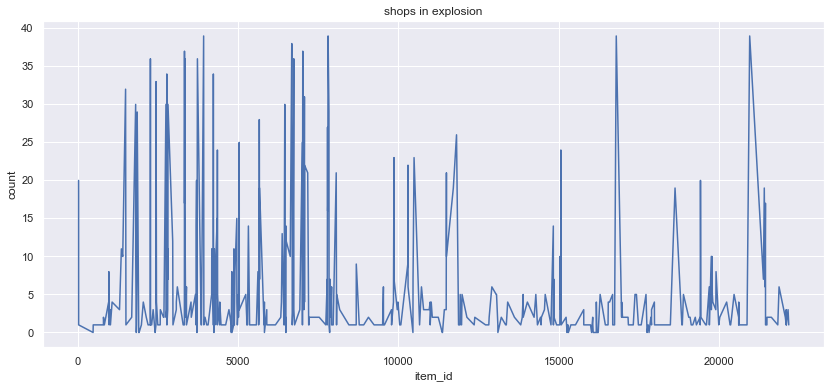

In [78]:
lpots = df_feature[df_feature.Starter != 0 ].groupby('item_id').agg(count = ('L0M_L1M', 'count')).reset_index()

fig = plt.figure(figsize=(14,6))
ax = sns.lineplot(x="item_id", y="count", data=lpots)
ax.set(title='shops in explosion')

<b> until here the patter is definetly by Item, then by shop, month of the year and maybe, the number of months 0 before explosion

visualization of the additional feature prediction

[Text(0.5, 1.0, 'shops in explosion')]

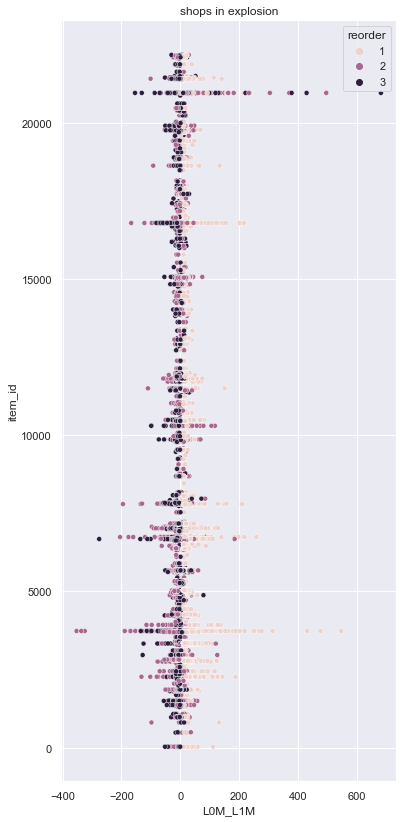

In [79]:
lpots = df_feature[(df_feature.pivotSep == 0) ]
fig = plt.figure(figsize=(6,14))
ax = sns.scatterplot(x="L0M_L1M", y="item_id", data=lpots, hue = 'reorder', s = 25)
ax.set(title='shops in explosion')

[Text(0.5, 1.0, 'shops min variation')]

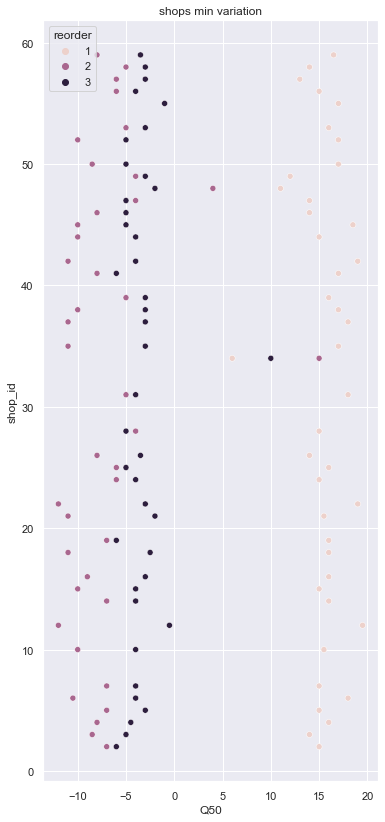

In [80]:
lpots = df_feature[(df_feature.pivotSep == 0) ].groupby(['shop_id','reorder']).agg(Min = ('L0M_L1M','min'),
                                                                                   Q50 = ('L0M_L1M',q2), Q75 = ('L0M_L1M',q3),
                                                                                   Max = ('L0M_L1M','max')).reset_index()

fig = plt.figure(figsize=(6,14))
ax = sns.scatterplot(x="Q50", y="shop_id", data=lpots, hue = 'reorder')
ax.set(title='shops min variation')

[Text(0.5, 1.0, 'shops in explosion')]

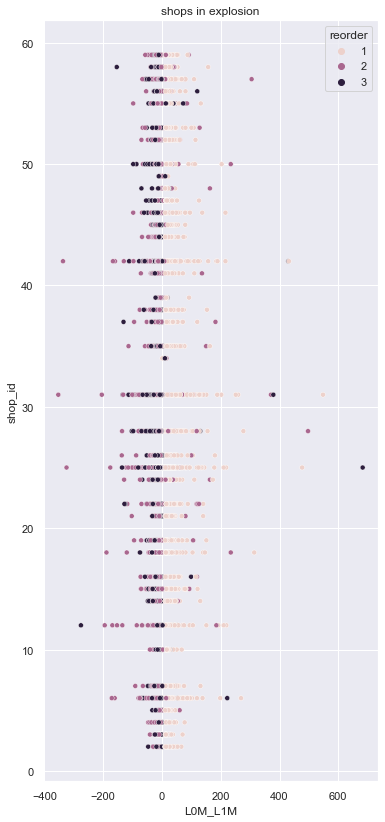

In [81]:
lpots = df_feature[(df_feature.pivotSep == 0) ]
fig = plt.figure(figsize=(6,14))
ax = sns.scatterplot(x="L0M_L1M", y="shop_id", data=lpots, hue = 'reorder', s = 25)
ax.set(title='shops in explosion')

[Text(0.5, 1.0, 'shops min variation')]

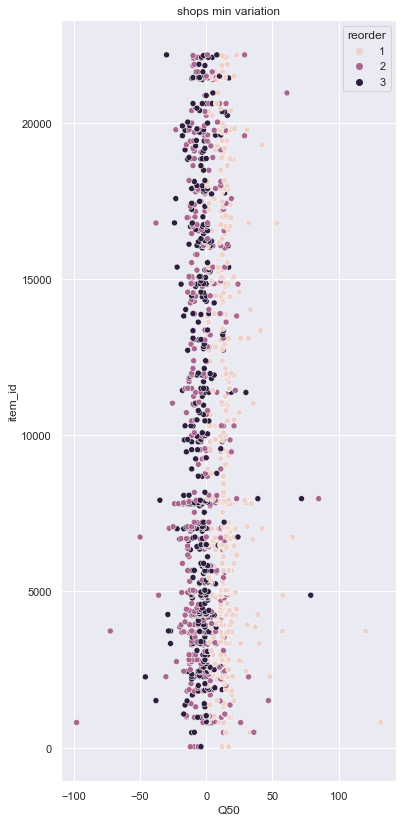

In [82]:
lpots = df_feature[(df_feature.pivotSep == 0) ].groupby(['item_id','reorder']).agg(Min = ('L0M_L1M','min'),
                                                                                   Q50 = ('L0M_L1M',q2), Q75 = ('L0M_L1M',q3),
                                                                                   Max = ('L0M_L1M','max')).reset_index()

fig = plt.figure(figsize=(6,14))
ax = sns.scatterplot(x="Q50", y="item_id", data=lpots, hue = 'reorder')
ax.set(title='shops min variation')

[Text(0.5, 1.0, 'months and item explosion')]

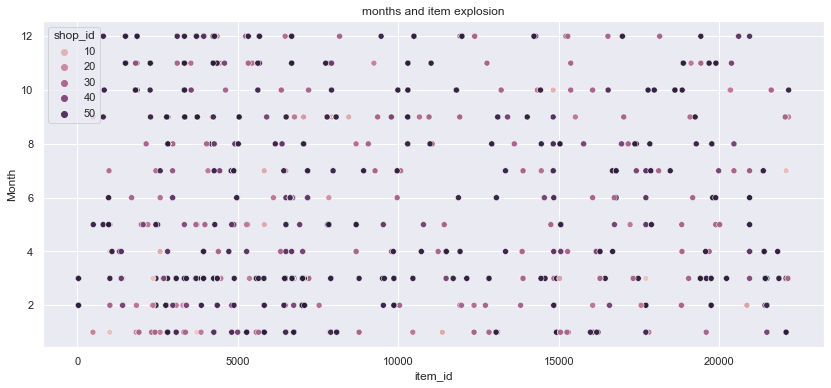

In [92]:
lpots = df_feature[df_feature.Starter != 0 ]

fig = plt.figure(figsize=(14,6))
ax = sns.scatterplot(x="item_id", y="Month", data=lpots, hue = 'shop_id')
ax.set(title='months and item explosion')

map the variation,
* count no variations before explotion
* get the variation by shop, item reorder 1 2 and 3 in a separate dictionary to create features
* take the median variation

the features are :

In [83]:
feature_item = df_feature[(df_feature.pivotSep == 0) ].groupby(['item_id','reorder']).agg(meanVarExplo = ('L0M_L1M','median')).reset_index()

In [84]:
feature_shop = df_feature[(df_feature.pivotSep == 0) ].groupby(['shop_id','reorder']).agg(meanVarExplo = ('L0M_L1M','median')).reset_index()

In [85]:
feature_month = df_feature[df_feature.Starter != 0 ].groupby('Month').agg(count = ('L0M_L1M', 'count')).reset_index()

result: three dictionaries, lag the reorder columns or reduce 1!!!

In [86]:
feature_item

,item_id,reorder,meanVarExplo
0,30,1,17.0
1,30,2,-9.0
2,30,3,-6.0
3,31,1,17.0
4,31,2,-12.0
...,...,...,...
1333,22166,2,1.0
1334,22166,3,8.0
1335,22167,1,29.0
1336,22167,2,29.0


#### High Variation Detection and features

In [37]:
df_feature = lag_train[['shop_id','item_id','shopitem','item_category_id','Date', 'Sale','Order', 'L0M_L1M','minVar','maxVar']].copy()
df_feature['count0'] = np.where(df_feature.Sale == 0,1,0)
df_feature['Month'] = df_feature['Date'].dt.month
df_feature['count0'] = df_feature.sort_values('Date').groupby(['shopitem']).count0.transform('sum')
df_feature['SaleNew'] = np.where(df_feature.Sale == 0,np.nan, df_feature.Sale)
df_feature['minSale'] = df_feature.sort_values('Date').groupby(['shopitem']).SaleNew.transform('min')

df_feature = df_feature[(abs(df_feature.maxVar) > 3) &(df_feature.count0 < 6)]

In [38]:
df_feature[df_feature.shopitem == '2-2808']

,shop_id,item_id,shopitem,item_category_id,Date,Sale,Order,L0M_L1M,minVar,maxVar,count0,Month,SaleNew,minSale
85,2,2808,2-2808,30,2013-01-01,17.0,1,NaN,-13.0,8.0,1,1,17.0,2.0
57290,2,2808,2-2808,30,2013-02-01,4.0,2,-13.0,-13.0,8.0,1,2,4.0,2.0
114495,2,2808,2-2808,30,2013-03-01,9.0,3,5.0,-13.0,8.0,1,3,9.0,2.0
171700,2,2808,2-2808,30,2013-04-01,4.0,4,-5.0,-13.0,8.0,1,4,4.0,2.0
228905,2,2808,2-2808,30,2013-05-01,4.0,5,0.0,-13.0,8.0,1,5,4.0,2.0
286110,2,2808,2-2808,30,2013-06-01,12.0,6,8.0,-13.0,8.0,1,6,12.0,2.0
343315,2,2808,2-2808,30,2013-07-01,3.0,7,-9.0,-13.0,8.0,1,7,3.0,2.0
400520,2,2808,2-2808,30,2013-08-01,4.0,8,1.0,-13.0,8.0,1,8,4.0,2.0
457725,2,2808,2-2808,30,2013-09-01,9.0,9,5.0,-13.0,8.0,1,9,9.0,2.0
514930,2,2808,2-2808,30,2013-10-01,0.0,10,-9.0,-13.0,8.0,1,10,NaN,2.0


[Text(0.5, 1.0, 'jijo')]

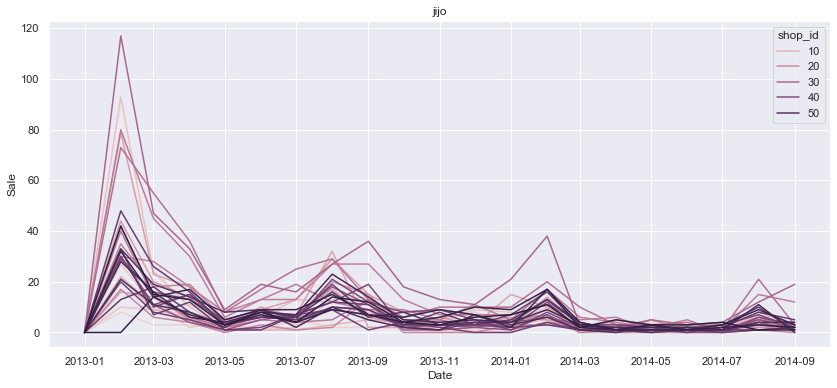

In [40]:
lpots = df_feature[df_feature.item_id == 2445]

fig = plt.figure(figsize=(14,6))
ax = sns.lineplot(x="Date", y="Sale", data=lpots, hue = 'shop_id')
ax.set(title='jijo')

[Text(0.5, 1.0, 'jijo')]

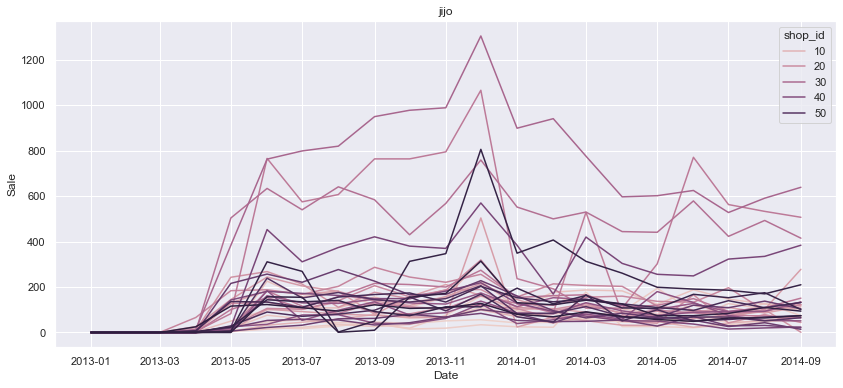

In [41]:
lpots = df_feature[df_feature.item_id == 20949]

fig = plt.figure(figsize=(14,6))
ax = sns.lineplot(x="Date", y="Sale", data=lpots, hue = 'shop_id')
ax.set(title='jijo')

In [42]:
df_feature.shop_id.unique()

array([ 2,  3,  4,  5,  6,  7, 10, 12, 14, 15, 16, 18, 19, 21, 22, 24, 25,
       26, 28, 31, 35, 37, 38, 41, 42, 44, 45, 46, 47, 50, 52, 53, 55, 56,
       57, 58, 59], dtype=int64)

[Text(0.5, 1.0, 'jijo')]

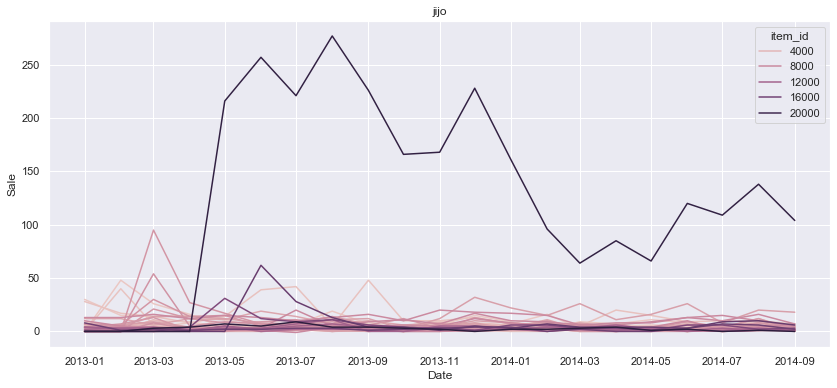

In [43]:
lpots = df_feature[df_feature.shop_id == 46]

fig = plt.figure(figsize=(14,6))
ax = sns.lineplot(x="Date", y="Sale", data=lpots, hue = 'item_id')
ax.set(title='jijo')

It is better to use the item Id

In [116]:
def q2(x):
    return x.quantile(0.50)

def q3(x):
    return x.quantile(0.95)

df_feature['Year'] = df_feature.Date.dt.year
df_feature['Quarter'] = np.where(df_feature.Month.isin([1,2,3]),1,
                            np.where(df_feature.Month.isin([4,5,6]),2,
                            np.where(df_feature.Month.isin([7,8,9]),3,
                            np.where(df_feature.Month.isin([10,11,12]),4,0))))

feature_med = df_feature.groupby(['item_id','Order','Year','Quarter','Month']).agg(medianVar = ('L0M_L1M',q2),
                                                                 highVar = ('L0M_L1M',q3)).reset_index()
feature_med['HighMeanQuart'] = feature_med.groupby(['Year','Quarter']).highVar.transform('mean')
feature_med['medianVarL12'] = feature_med.sort_values('Order').groupby(['item_id'])['medianVar'].shift(12)
feature_med['HighVarL12'] = feature_med.sort_values('Order').groupby(['item_id'])['highVar'].shift(12)

feature_var_season = feature_med.groupby(['item_id','Year','Quarter'])[['HighMeanQuart']].max().reset_index()
feature_var_season['HighMeanQuartL4'] = feature_var_season.sort_values(['Year','Quarter']).groupby(['item_id'])['HighMeanQuart'].shift(4)
feature_var_season = feature_var_season.fillna(0)
feature_var_season['SeasonalVariation'] = feature_var_season.HighMeanQuart - feature_var_season.HighMeanQuartL4
feature_var_season = feature_var_season.drop(columns = 'HighMeanQuart')


feature_med = feature_med.merge(feature_var_season, on = ['item_id','Year','Quarter'],how = 'left')
feature_med = feature_med[['item_id','Order','Year','Month','medianVarL12','SeasonalVariation','HighVarL12']]

In [118]:
feature_med

,item_id,Order,Year,Month,medianVarL12,SeasonalVariation,HighVarL12
0,30,1,2013,1,NaN,3.304620,NaN
1,30,2,2013,2,NaN,3.304620,NaN
2,30,3,2013,3,NaN,3.304620,NaN
3,30,4,2013,4,NaN,2.756491,NaN
4,30,5,2013,5,NaN,2.756491,NaN
...,...,...,...,...,...,...,...
6358,22092,17,2014,5,3.0,-2.015622,3.0
6359,22092,18,2014,6,-1.0,-2.015622,0.8
6360,22092,19,2014,7,0.0,-0.257481,1.8
6361,22092,20,2014,8,1.0,-0.257481,1.0


modeling of the feature using:
* monthly mediqn of an item (previous year) 
* monthly q95 of an item (previous year)
* seasonal corrector using q95 of an item using quarters